In [ ]:
import requests
import pandas as pd
import concurrent.futures
import time
import csv
from shapely.geometry import shape, mapping

Парсим атрибуты

In [15]:
# URL для получения атрибутов дороги
BASE_URL_ATTR = "https://xn--d1aluo.xn--p1ai/api-skdf/api/v1/portal/map/mini-passport/{}"
# URL для получения геометрии
BASE_URL_GEOM = "https://xn--d1aluo.xn--p1ai/api-pg/rpc/f_get_object_geom"
# Заголовки для запроса геометрии
HEADERS_GEOM = {
    "Accept": "application/json, text/plain, */*",
    "Content-Type": "application/json",
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36",
    "Cookie": "_ym_uid=1741007348961157402; _ym_d=1741007348; _ym_isad=2; _ym_visorc=w",
    "Content-profile": "gis_api_public"
}

# Имя CSV-файла для сохранения
CSV_FILE = "roads_data.csv"
# Параметры потоковой обработки и задержка между запросами
MAX_WORKERS = 8
DELAY = 0.1  
# Диапазон идентификаторов дорог
ROAD_IDS = range(89001, 89100)

# Функция для поиска значения по коду поля в списке полей
def extract_field(fields, field_code):
    for field in fields:
        if field["code"] == field_code:
            return field["value"]["value"]
    return ""

def fetch_geometry(object_id):
    payload = {"object_id": object_id, "object_type": 4}  # object_type: 4 - дороги
    try:
        response = requests.post(BASE_URL_GEOM, headers=HEADERS_GEOM, json=payload, timeout=10)
        response.raise_for_status()
        geo_data = response.json()
        # Используем логику из вашего примера:
        features = geo_data.get("features", [])
        if features:
            geom_dict = features[0].get("geometry")
            if geom_dict:
                geom_obj = shape(geom_dict)
                return geom_obj.wkt  # Возвращаем геометрию в формате WKT
            else:
                return None
        else:
            return None
    except requests.RequestException:
        return None

# Функция для получения атрибутов дороги и её геометрии
def fetch_data(road_id):
    url = BASE_URL_ATTR.format(road_id)
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        fields = data.get("fields", [])
        geometry_wkt = fetch_geometry(road_id)
        
        result = {
            "road_id": road_id,
            "name": extract_field(fields, "FULL_NAME"),       # Наименование дороги
            "region": extract_field(fields, "REGION"),          # Регион
            "category": extract_field(fields, "ROAD_CATEGORY"), # Категория
            "length_km": extract_field(fields, "LENGTH_POPIKETNO"),  # Протяженность
            "lanes": extract_field(fields, "RANKS"),            # Число полос
            "coating": extract_field(fields, "COATING"),        # Покрытие
            "cost": extract_field(fields, "COST"),              # Стоимость работ
            "status": extract_field(fields, "CLASS_OF_ROAD"),   # Класс дороги
            "geometry": geometry_wkt                          # Геометрия в формате WKT
        }
    
        # Если атрибут "name" пустой, возвращаем None, чтобы пропустить эту запись
        if not result["name"]:
            return None
        
        return result
        
    except requests.RequestException:
        return None

# Генератор для параллельного получения данных по каждому road_id
def road_data_generator(road_ids):
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(fetch_data, road_id): road_id for road_id in road_ids}
        for future in concurrent.futures.as_completed(futures):
            data = future.result()
            if data:
                yield data
            time.sleep(DELAY)  # Задержка между запросами

# Функция для записи полученных данных в CSV-файл
def save_to_csv(generator):
    with open(CSV_FILE, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=[
            "road_id", "name", "region", "category", "length_km", 
            "lanes", "coating", "cost", "status", "geometry"
        ])
        writer.writeheader()
        for data in generator:
            writer.writerow(data)

if __name__ == "__main__":
    save_to_csv(road_data_generator(ROAD_IDS))
    print(f"Данные успешно сохранены в {CSV_FILE}")


Данные успешно сохранены в roads_data.csv


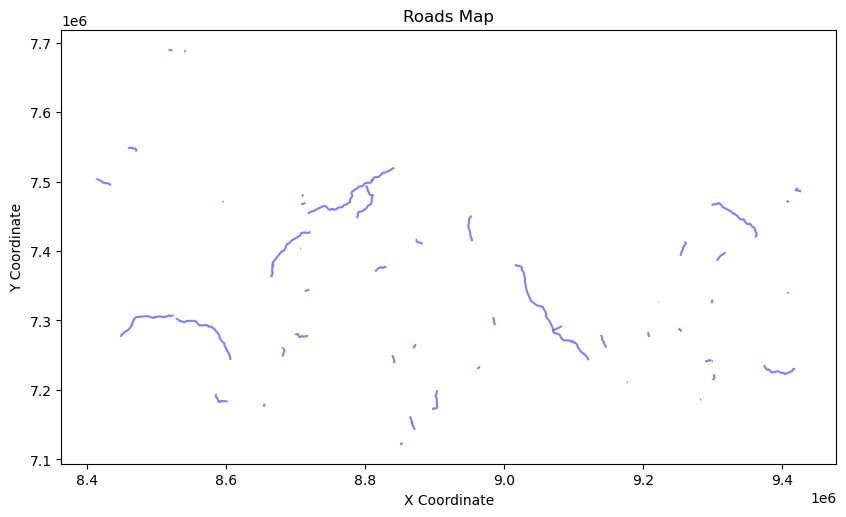

In [18]:
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# Read the CSV file containing road data and geometry in WKT format
df = pd.read_csv("roads_data.csv")

# Convert the 'geometry' column from WKT to Shapely geometry objects
df["geometry"] = df["geometry"].apply(wkt.loads)

# Create a GeoDataFrame, specifying the coordinate reference system (CRS)
# Assuming the WKT geometries are in EPSG:3857 (Web Mercator)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:3857")

# (Optional) Reproject to EPSG:4326 (latitude/longitude) if desired:
#gdf = gdf.to_crs(epsg=4326)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="blue", edgecolor="black", alpha=0.5)
ax.set_title("Roads Map")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
plt.show()